In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 파일 불러오기
info_df = pd.read_csv("통합_정보.csv", encoding='euc-kr')
combined_df = pd.read_csv("통합_정보_합침.csv", encoding='euc-kr')
matched_books_df = pd.read_csv("matched_books.csv", encoding='utf-8')
decade_rank_df = pd.read_csv("통합_정보_연대별_대출횟수_순위포함.csv", encoding='euc-kr')

# 중복책권수 데이터 변환 및 확인
combined_df['중복책권수'] = pd.to_numeric(combined_df['중복책권수'].replace(',', '', regex=True), errors='coerce').fillna(0).astype(int)

# 도서ID 분할: ',' 기준으로 여러 도서ID가 있는 경우 나눔
duplicated_rows = combined_df[combined_df['도서ID'].str.contains(',')]
split_rows = duplicated_rows.assign(도서ID=duplicated_rows['도서ID'].str.split(',')).explode('도서ID')

# 공백 제거
split_rows['도서ID'] = split_rows['도서ID'].str.strip()
combined_df = pd.concat([combined_df[~combined_df['도서ID'].str.contains(',')], split_rows], ignore_index=True)

# 1. '마지막 대출일자'와 '총 대출수' 기준 점수 계산
info_df['마지막 대출일자'] = pd.to_datetime(info_df['마지막대출일자'], errors='coerce')
min_date = info_df['마지막 대출일자'].min()

def last_loan_priority(date):
    if pd.isna(date):
        return 1  # '대출 기록 없음'에 가장 높은 점수 부여
    return (date - min_date).days  # 오래된 대출일수록 낮은 점수

info_df['대출일자_점수'] = info_df['마지막 대출일자'].apply(last_loan_priority)
info_df['대출일자_점수'] = MinMaxScaler().fit_transform(info_df[['대출일자_점수']])  # 정규화

# '총 대출수' 처리 (대출 수가 적을수록 높은 점수 부여)
info_df['총대출수'] = pd.to_numeric(info_df['총대출수'], errors='coerce').fillna(0)
info_df['대출수_점수'] = 1 - MinMaxScaler().fit_transform(info_df[['총대출수']])  # 대출 수 적을수록 높은 점수

# 가중치 1의 최종 점수 (대출일자 70%, 총대출수 30% 반영)
info_df['우선순위_1'] = 0.7 * info_df['대출일자_점수'] + 0.3 * info_df['대출수_점수']

# 2. '중복책권수' 기준 점수 계산 (1인 값은 0으로 설정하고, 2 이상만 정규화)
combined_df['우선순위_2'] = 0

# 2 이상인 값만 비율 기반 변환하여 정규화
mask = combined_df['중복책권수'] > 1
if mask.any():
    scaler = MinMaxScaler()
    combined_df.loc[mask, '우선순위_2'] = scaler.fit_transform(combined_df.loc[mask, ['중복책권수']])

# 3. '출판년도' 기준 점수 계산 (오래된 출판년도일수록 높은 점수)
combined_df['출판년도'] = pd.to_numeric(combined_df['출판년도'], errors='coerce').fillna(0)
combined_df['출판년도_점수'] = 1 - MinMaxScaler().fit_transform(combined_df[['출판년도']])
combined_df['우선순위_3'] = combined_df['출판년도_점수']

# 4. 전자책으로 대체할 수 있는 책 점수 계산 (matched_books_df 이용)
matched_books_set = set(matched_books_df['Matched Book Title'].str.strip())
combined_df['우선순위_4'] = combined_df['서명'].apply(lambda title: 1 if title in matched_books_set else 0)  # 가중치 0.5 적용

# 5. 증가율 순위를 이용한 우선순위 점수 계산
decade_rank_map = dict(zip(decade_rank_df['서명'], decade_rank_df['증가율순위']))
combined_df['우선순위_5'] = combined_df['서명'].map(decade_rank_map).fillna(max(decade_rank_df['증가율순위']) + 1)
combined_df['우선순위_5'] = 1 - MinMaxScaler().fit_transform(combined_df[['우선순위_5']])  # 순위를 역순으로 정규화하여 낮은 순위일수록 높은 점수

# 최종 점수 계산 (가중치: 1 > 2 > 3 > 4 > 5)
final_df = pd.merge(info_df[['도서ID', '우선순위_1']], combined_df[['도서ID', '중복책권수', '우선순위_2', '우선순위_3', '우선순위_4', '우선순위_5']], on='도서ID', how='inner')
final_df['최종우선순위_점수'] = 0.35 * final_df['우선순위_1'] + 0.25 * final_df['우선순위_2'] + 0.2 * final_df['우선순위_3'] + 0.15 * final_df['우선순위_4'] + 0.05 * final_df['우선순위_5']

# 우선순위 정렬 및 저장
final_df = final_df.sort_values(by='최종우선순위_점수', ascending=False)
final_df.to_csv("최종_우선순위_분석목적1.csv", index=False, encoding='euc-kr')

# 결과 미리보기
print(final_df.head())

KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
# MacOS일 경우
plt.rcParams['font.family'] = 'AppleGothic'

# Windows일 경우
# plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

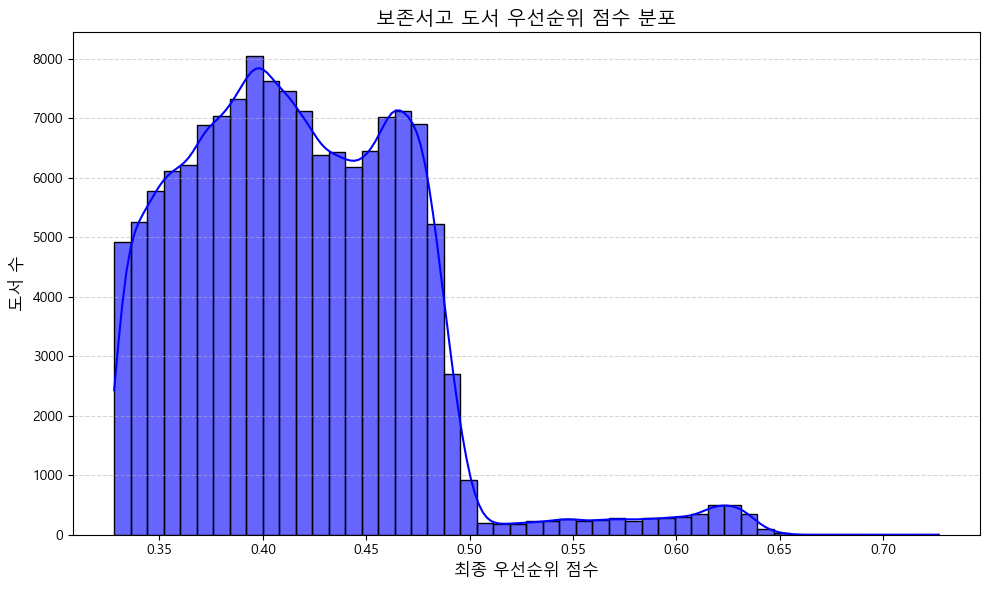

In [ ]:
import seaborn as sns

# CSV 파일 불러오기
final_df = pd.read_csv("최종_우선순위_분석목적1.csv", encoding='euc-kr')

# 우선순위 상위 약 140,000개 도서 필터링
preservation_books = final_df.head(140000)

### **우선순위 점수 분포 시각화 (히스토그램)**
plt.figure(figsize=(10, 6))
sns.histplot(preservation_books['최종우선순위_점수'], bins=50, kde=True, color='blue', alpha=0.6)

# 그래프 제목 및 라벨 설정
plt.title('보존서고 도서 우선순위 점수 분포', fontsize=14)
plt.xlabel('최종 우선순위 점수', fontsize=12)
plt.ylabel('도서 수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 파일 불러오기
info_df = pd.read_csv("통합_정보.csv", encoding='euc-kr')
combined_df = pd.read_csv("통합_정보_합침.csv", encoding='euc-kr')
matched_books_df = pd.read_csv("matched_books.csv", encoding='utf-8')
decade_rank_df = pd.read_csv("통합_정보_연대별_대출횟수_순위포함.csv", encoding='euc-kr')

# 중복책권수 데이터 변환 및 확인
combined_df['중복책권수'] = pd.to_numeric(combined_df['중복책권수'].replace(',', '', regex=True), errors='coerce').fillna(0).astype(int)

# 도서ID 분할: ',' 기준으로 여러 도서ID가 있는 경우 나눔
duplicated_rows = combined_df[combined_df['도서ID'].str.contains(',')]
split_rows = duplicated_rows.assign(도서ID=duplicated_rows['도서ID'].str.split(',')).explode('도서ID')

# 공백 제거
split_rows['도서ID'] = split_rows['도서ID'].str.strip()
combined_df = pd.concat([combined_df[~combined_df['도서ID'].str.contains(',')], split_rows], ignore_index=True)

# 증가율 순위를 새로운 우선순위 1로 설정 (높은 증가율 순위에 높은 점수)
decade_rank_map = dict(zip(decade_rank_df['서명'], decade_rank_df['증가율순위']))
combined_df['우선순위_1'] = combined_df['서명'].map(decade_rank_map).fillna(max(decade_rank_df['증가율순위']) + 1)

# 낮은 순위(값)일수록 낮은 점수, 높은 순위일수록 높은 점수로 변환
combined_df['우선순위_1'] = 1 - MinMaxScaler().fit_transform(combined_df[['우선순위_1']])  # 순위 뒤집기 완료

# 중복책권수: 그대로 두고 1에서 점수 뺌
scaler = MinMaxScaler()
combined_df['우선순위_2'] = scaler.fit_transform(combined_df[['중복책권수']])
combined_df['우선순위_2'] = 1 - combined_df['우선순위_2']  # 역순 변환

# 마지막 대출일: 그대로 두고 1에서 점수 뺌
info_df['마지막 대출일자'] = pd.to_datetime(info_df['마지막대출일자'], errors='coerce')
min_date = info_df['마지막 대출일자'].min()

def last_loan_priority(date):
    if pd.isna(date):
        return 0  # 대출 기록 없음일 경우 낮은 점수
    return (date - min_date).days  # 오래된 날짜일수록 높은 값

info_df['우선순위_3'] = info_df['마지막 대출일자'].apply(last_loan_priority)
info_df['우선순위_3'] = MinMaxScaler().fit_transform(info_df[['우선순위_3']])
info_df['우선순위_3'] = 1 - info_df['우선순위_3']  # 역순 변환

# 출판년도: 그대로 두고 1에서 점수 뺌
combined_df['출판년도'] = pd.to_numeric(combined_df['출판년도'], errors='coerce').fillna(0)
combined_df['우선순위_4'] = MinMaxScaler().fit_transform(combined_df[['출판년도']])
combined_df['우선순위_4'] = 1 - combined_df['우선순위_4']  # 역순 변환

# 전자책 대체 가능 여부: 가능하면 0점, 불가능하면 1점 (그대로 유지)
matched_books_set = set(matched_books_df['Matched Book Title'].str.strip())
combined_df['우선순위_5'] = combined_df['서명'].apply(lambda title: 0 if title in matched_books_set else 1)

# 십진분류 추가: decade_rank_df에서 서명을 기준으로 매칭
combined_df = combined_df.merge(decade_rank_df[['서명', '십진분류']], on='서명', how='left')

# 최종 점수 계산 (가중치 설정)
final_df = pd.merge(info_df[['도서ID', '우선순위_3']], combined_df[['도서ID', '우선순위_1', '우선순위_2', '우선순위_4', '우선순위_5', '십진분류']], on='도서ID', how='inner')
final_df['최종우선순위_점수'] = (
    0.5 * final_df['우선순위_1'] +  # 증가율 순위
    0.20 * final_df['우선순위_2'] +  # 중복책권수
    0.15 * final_df['우선순위_3'] +  # 마지막 대출일
    0.1 * final_df['우선순위_4'] +  # 출판년도
    0.05 * final_df['우선순위_5']    # 전자책 대체 가능 여부
)

# 우선순위 정렬 및 저장
final_df = final_df.sort_values(by='최종우선순위_점수', ascending=False)
final_df.to_csv("최종_우선순위_분석목적2.csv", index=False, encoding='euc-kr')

# 결과 미리보기
print(final_df.head())


C:\Users\songbh0304\AppData\Local\Temp\ipykernel_23036\2739338611.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  decade_rank_df = pd.read_csv("통합_정보_연대별_대출횟수_순위포함.csv", encoding='euc-kr')
C:\Users\songbh0304\AppData\Local\Temp\ipykernel_23036\2739338611.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  info_df['마지막 대출일자'] = pd.to_datetime(info_df['마지막대출일자'], errors='coerce')


             도서ID  우선순위_3    우선순위_1    우선순위_2  우선순위_4  우선순위_5 십진분류  최종우선순위_점수
268883  SS_198018     1.0  0.986301  1.000000     1.0       1  480   0.993151
21988   SS_198077     1.0  0.931507  1.000000     1.0       1  470   0.965753
55273   SS_197157     1.0  0.945205  0.962312     1.0       1  060   0.965065
55268   SS_197162     1.0  0.945205  0.962312     1.0       1  060   0.965065
55269   SS_197161     1.0  0.945205  0.962312     1.0       1  060   0.965065


C:\Users\songbh0304\AppData\Local\Temp\ipykernel_23036\2524622268.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='도서수', y='십진분류', data=top_20_classifications, palette='viridis')


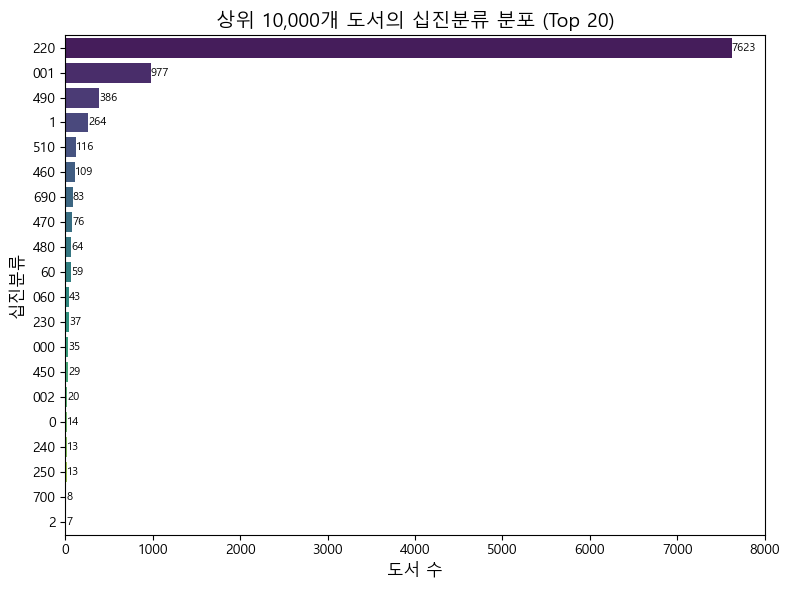

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (예: Malgun Gothic)
plt.rc('font', family='Malgun Gothic')

# CSV 파일 불러오기
final_df = pd.read_csv("최종_우선순위_분석목적2.csv", encoding='euc-kr', low_memory=False)

# 우선순위 상위 10,000개 도서 필터링
top_10000_books = final_df.head(10000)

# 십진분류별 분포 추출
classification_distribution = top_10000_books['십진분류'].value_counts().reset_index()
classification_distribution.columns = ['십진분류', '도서수']

# 상위 20개 십진분류 선택
top_20_classifications = classification_distribution.head(20)

# 시각화
plt.figure(figsize=(8, 6))  # 크기를 줄여 오류 방지
sns.barplot(x='도서수', y='십진분류', data=top_20_classifications, palette='viridis')

# 그래프 제목 및 라벨 설정
plt.title('상위 10,000개 도서의 십진분류 분포 (Top 20)', fontsize=14)
plt.xlabel('도서 수', fontsize=12)
plt.ylabel('십진분류', fontsize=12)

# 값 표시 (너무 길지 않게 조정)
for i, row in top_20_classifications.iterrows():
    plt.text(row['도서수'] + 2, i, str(row['도서수']), va='center', fontsize=8)

plt.tight_layout()
plt.show()


In [19]:
final_df = pd.read_csv("최종_우선순위_분석목적2.csv", encoding='euc-kr')
book_info_df = pd.read_csv("단행본(도서)정보.csv", encoding='euc-kr')
top_10000_books = final_df.head(10000)

# 십진분류별 분포 추출
classification_distribution = top_10000_books['십진분류'].value_counts().reset_index()
classification_distribution.columns = ['십진분류', '도서수']
# 상위 도서ID 추출 (충분한 수)
top_book_ids = final_df['도서ID'].tolist()

# 도서ID를 기준으로 서명 매칭
books_with_titles = book_info_df[book_info_df['도서ID'].isin(top_book_ids)][['도서ID', '서명']]

# 중복 서명 제거하고 고유한 상위 20개 서명 추출
unique_titles = books_with_titles.drop_duplicates(subset=['서명']).head(20)

# 결과 출력
print("\n고유한 상위 20개의 도서 서명:")
print(unique_titles)

C:\Users\songbh0304\AppData\Local\Temp\ipykernel_23036\2010233897.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv("최종_우선순위_분석목적2.csv", encoding='euc-kr')
C:\Users\songbh0304\AppData\Local\Temp\ipykernel_23036\2010233897.py:2: DtypeWarning: Columns (3,4,22) have mixed types. Specify dtype option on import or set low_memory=False.
  book_info_df = pd.read_csv("단행본(도서)정보.csv", encoding='euc-kr')



고유한 상위 20개의 도서 서명:
         도서ID                                                 서명
0   SS_270312  Le courage de la verite :le gouvernement de so...
1   SS_233793                                         김나지움 논리학입문
3   SS_075978                                          선제논리를 향하여
5   SS_291967                                            이것이 야구다
7   SS_138245               Treffpunkt D-A-CH :Landeskundeheft 3
8   SS_143820                          Practical public speaking
9   SS_026726  The Crisis of Leninism and the decline of the ...
10  SS_267339                                              참된 목자
11  SS_052283                                 (漢字音으로 본) 백제어 자음체계
13  SS_229973                                             토라의 신학
15  SS_000298                      Appel :initiation au fran?ais
16  SS_289544                                       어느 아나키스트의 고백
18  SS_115953                                             독어학 입문
21  SS_043824                                   시대와 인물, 그리고 사회의식
23  S

In [22]:

# 우선순위 상위 10,000개 도서 필터링
top_10000_books = final_df.head(10000)

# 십진분류별 분포 추출
classification_distribution = top_10000_books['십진분류'].value_counts().reset_index()
classification_distribution.columns = ['십진분류', '도서수']

# 상위 20개 십진분류 추출
top_20_classifications = classification_distribution.head(20)
top_20_classifications

,십진분류,도서수
0,220,7623
1,001,977
2,490,386
3,1,264
4,510,116
5,460,109
6,690,83
7,470,76
8,480,64
9,60,59
